<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Configuration" data-toc-modified-id="Configuration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Free-energy-profile" data-toc-modified-id="Free-energy-profile-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Free energy profile</a></span></li></ul></div>

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.cv import CoordinationNumber, Difference
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, BaseFreeEnergyProfile, plot_feps
from thermolib.thermodynamics.histogram import Histogram1D, plot_histograms
from thermolib.tools import read_wham_input, blav

import numpy as np

from molmod.units import *

# Configuration

Unit cell definition

In [3]:
lengths =  np.array([18.7471,18.7471,18.7471])*angstrom
angles = np.array([90.0, 90.0, 90.0])*deg

Collective variable definition

In [4]:
# methoxy_proton: COORDINATION GROUPA=527 GROUPB=173-515,526 R_0=1.3
# carbon_methoxy: COORDINATION GROUPA=527 GROUPB=516 R_0=1.8
# cv1: MATHEVAL ARG=carbon_methoxy,methoxy_proton FUNC=y-x PERIODIC=NO

hwat_indices = np.arange(173-1,515-1,1)
hwat_indices = np.concatenate((hwat_indices,[526-1]))
methoxy_oxygen_proton = np.full((len(hwat_indices),2),527-1)
carbon_methoxy = np.array([[527-1,516-1]])
methoxy_oxygen_proton[:,0] = hwat_indices
methoxy_oxygen_proton_cn = CoordinationNumber(methoxy_oxygen_proton,r0=1.3*angstrom, unit_cell_pars=[lengths,angles])
carbon_methoxy_cn = CoordinationNumber(carbon_methoxy,r0=1.8*angstrom, unit_cell_pars=[lengths,angles])
#diff is cv2 - cv1 (with Diff(Cv1,cv2))
CV = Difference(carbon_methoxy_cn,methoxy_oxygen_proton_cn)
CV_TS_lims = [-0.1,0.4] # based on the combined profile

# Histogram

In [5]:
#Read free energy profile
temp = 523*kelvin
fn1 = '/home/louis/hpc/data/shared/Elias-Louis/error_estimation_US/r1/COLVAR'
fn2 = '/home/louis/hpc/data/shared/Elias-Louis/error_estimation_US/r2/COLVAR'
fn3 = '/home/louis/hpc/data/shared/Elias-Louis/error_estimation_US/r3/COLVAR'
cv_data_1 = np.loadtxt(fn1)[:,1]*angstrom
cv_data_2 = np.loadtxt(fn2)[:,1]*angstrom
cv_data_3 = np.loadtxt(fn3)[:,1]*angstrom
cv_data = np.concatenate([cv_data_1,cv_data_2,cv_data_3])
bins = np.arange(-1.0,-0.08,0.02)*angstrom

## Blav analysis to estimate correlation time

<Figure size 432x288 with 0 Axes>

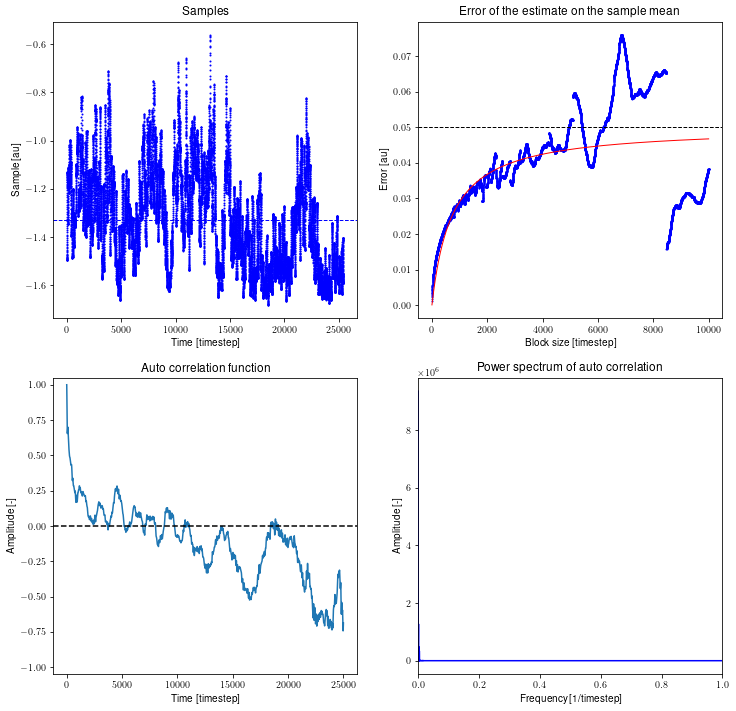

Correlation time = 727.185 timesteps


<Figure size 432x288 with 0 Axes>

In [6]:
mean, error, corrtime = blav(cv_data_1[::1], blocksizes=np.arange(1,10000,1), fitrange=[100,5000], fn_plot='trajectory_blav.png', plot_ac=True, ac_range=np.arange(0,25000,1), acft_plot_range=[0,1])
print('Correlation time = %.3f timesteps' %corrtime)

## Construct histogram from entire trajectory without error

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

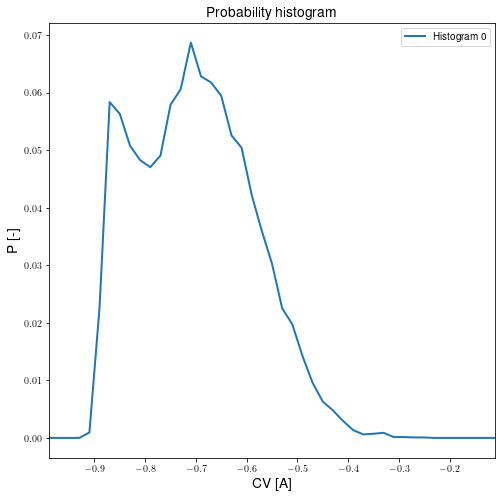

In [7]:
hist = Histogram1D.from_single_trajectory(cv_data, bins, error_estimate=None, cv_unit='A')
hist.plot('histogram_noerror.png')

<Figure size 432x288 with 0 Axes>

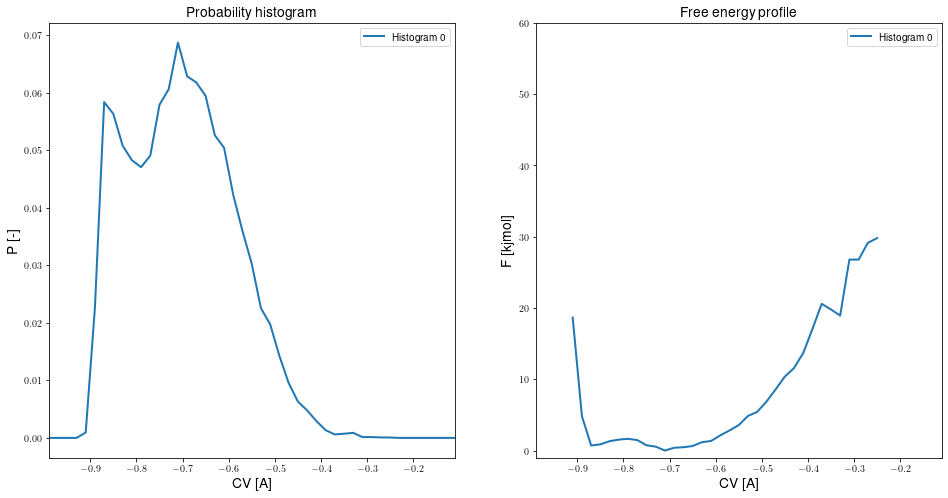

In [8]:
hist.plot('histogram_noerror_withF.png', temp=temp, flim=60*kjmol)

## Construct histogram from entire trajectory with error from MLE

<Figure size 432x288 with 0 Axes>

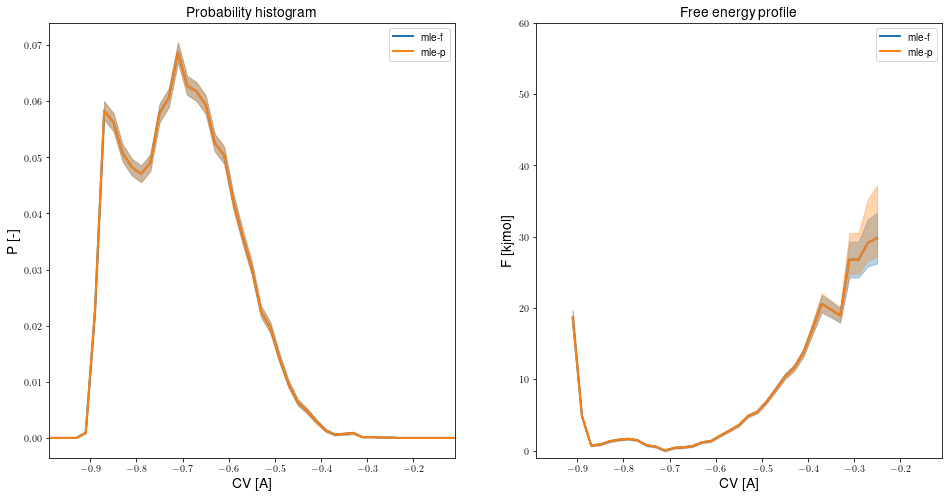

In [9]:
#estimate error on MLE of probability itself
hist_mle_p = Histogram1D.from_single_trajectory(cv_data, bins, error_estimate='mle_p', cv_unit='A')
#estimate error on MLE of free energy
hist_mle_f = Histogram1D.from_single_trajectory(cv_data, bins, error_estimate='mle_f', cv_unit='A')
plot_histograms('histogram_errors_withF.png', [hist_mle_f,hist_mle_p], temp=temp, labels=['mle-f','mle-p'], flim=60*kjmol)

Do the same as above, but now with sub sampling 1 in 100 (decreasing correlation) which increases error and reveals difference between the two error estimation methods

<Figure size 432x288 with 0 Axes>

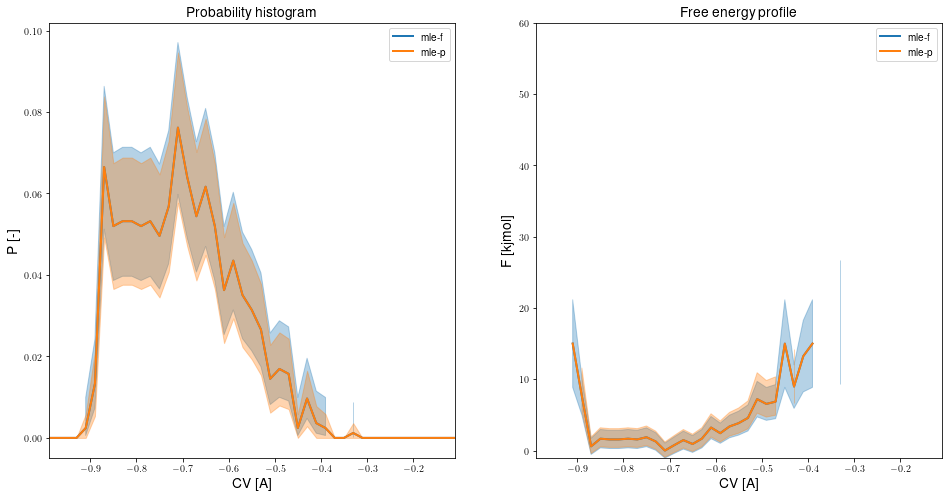

In [10]:
#estimate error on MLE of probability itself
hist_mle_p = Histogram1D.from_single_trajectory(cv_data[::100], bins, error_estimate='mle_p', cv_unit='A')
#estimate error on MLE of free energy
hist_mle_f = Histogram1D.from_single_trajectory(cv_data[::100], bins, error_estimate='mle_f', cv_unit='A')
plot_histograms('histogram_subsampled_errors_withF.png', [hist_mle_f,hist_mle_p], temp=temp, labels=['mle-f','mle-p'], flim=60*kjmol)

## Construct histogram with error from block analysis

Constructing histogram for block [0,41348]
Constructing histogram for block [41348,82696]


<Figure size 432x288 with 0 Axes>

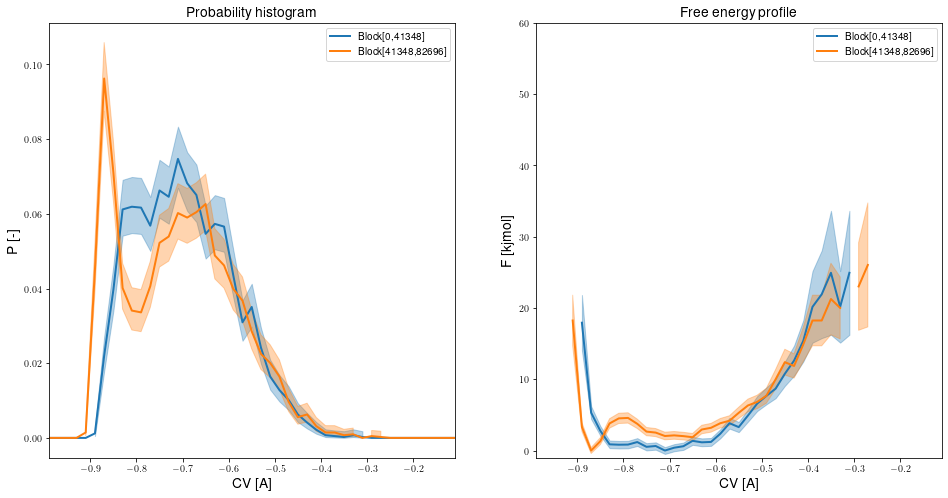

In [11]:
nblocks = 2
blocksize = len(cv_data)//nblocks
histograms = []
labels = []
for iblock in range(nblocks):
    start, end = iblock*blocksize, (iblock+1)*blocksize
    print("Constructing histogram for block [%i,%i]" %(start,end))
    hist = Histogram1D.from_single_trajectory(cv_data[start:end:10], bins, error_estimate='mle_f', cv_unit='A')
    histograms.append(hist)
    labels.append("Block[%i,%i]"%(start,end))
plot_histograms('histogram_blocks_withF.png', histograms, labels=labels, temp=temp, flim=60*kjmol)

In the following we will consider 6 blocks of the original trajectory for which we will estimate a histogram. Afterwards we will average the histograms and compute corresponding error. The free energy profile of the average histogram is afterwards computed.

Constructing histogram for block [0,13782]
Constructing histogram for block [13782,27564]
Constructing histogram for block [27564,41346]
Constructing histogram for block [41346,55128]
Constructing histogram for block [55128,68910]
Constructing histogram for block [68910,82692]


<Figure size 432x288 with 0 Axes>

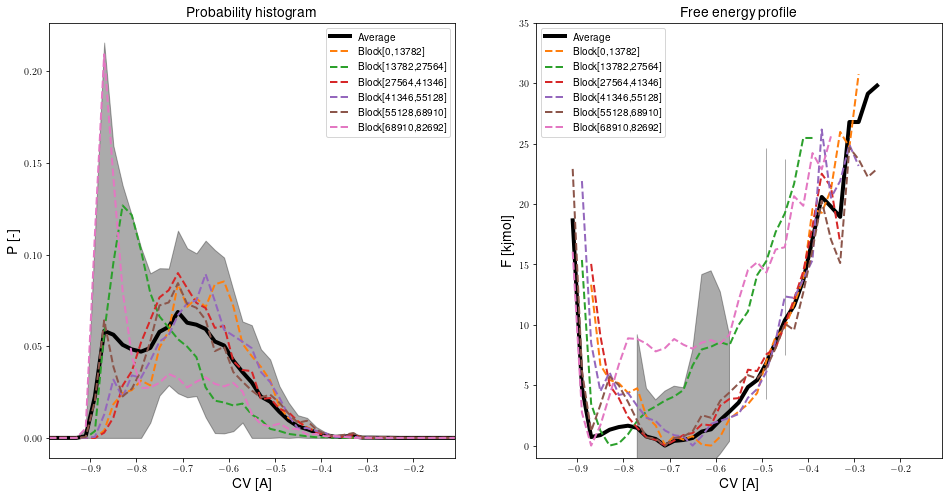

In [18]:
nblocks = 6
blocksize = len(cv_data)//nblocks
histograms = []
labels = []
for iblock in range(nblocks):
    start, end = iblock*blocksize, (iblock+1)*blocksize
    print("Constructing histogram for block [%i,%i]" %(start,end))
    hist = Histogram1D.from_single_trajectory(cv_data[start:end:1], bins, error_estimate=None, cv_unit='A')
    histograms.append(hist)
    labels.append("Block[%i,%i]"%(start,end))
hist_blav_1 = Histogram1D.from_average(histograms, error_estimate='std', nsigma=2)
plot_histograms('histblav.png', [hist_blav_1]+histograms, labels=['Average']+labels, temp=temp, flim=35*kjmol, 
                colors    =['k']+[None,]*nblocks, 
                linestyles=['-']+['--',]*nblocks, 
                linewidths=[4  ]+[2   ,]*nblocks)

In the following we will consider 6 blocks of the original trajectory for which we will estimate a histogram and compute the corresponding the free energy profile. Afterwards we will average the free energy profiles and compute corresponding error. The histogram of the average free energy profile is afterwards computed.

Constructing histogram for block [0,13782]
Constructing histogram for block [13782,27564]
Constructing histogram for block [27564,41346]
Constructing histogram for block [41346,55128]
Constructing histogram for block [55128,68910]
Constructing histogram for block [68910,82692]


<Figure size 432x288 with 0 Axes>

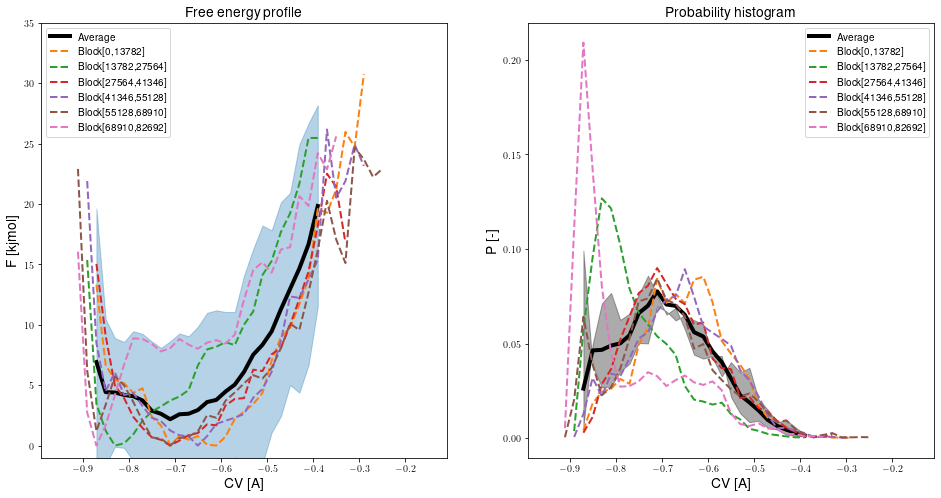

In [14]:
nblocks = 6
blocksize = len(cv_data)//nblocks
feps = []
labels = []
for iblock in range(nblocks):
    start, end = iblock*blocksize, (iblock+1)*blocksize
    print("Constructing histogram for block [%i,%i]" %(start,end))
    hist = Histogram1D.from_single_trajectory(cv_data[start:end:1], bins, error_estimate=None, cv_unit='A')
    fep = BaseFreeEnergyProfile.from_histogram(hist, temp)
    fep.set_ref(ref='min')
    feps.append(fep)
    labels.append("Block[%i,%i]"%(start,end))
fep_blav_2 = BaseFreeEnergyProfile.from_average(feps, error_estimate='std', nsigma=2)
plot_feps('fepblav.png', [fep_blav_2]+feps, labels=['Average']+labels, temp=temp, flim=35*kjmol,
                colors    =['k']+[None,]*nblocks, 
                linestyles=['-']+['--',]*nblocks, 
                linewidths=[4  ]+[2   ,]*nblocks)

Compare the resulting two averaged profiles from above

<Figure size 432x288 with 0 Axes>

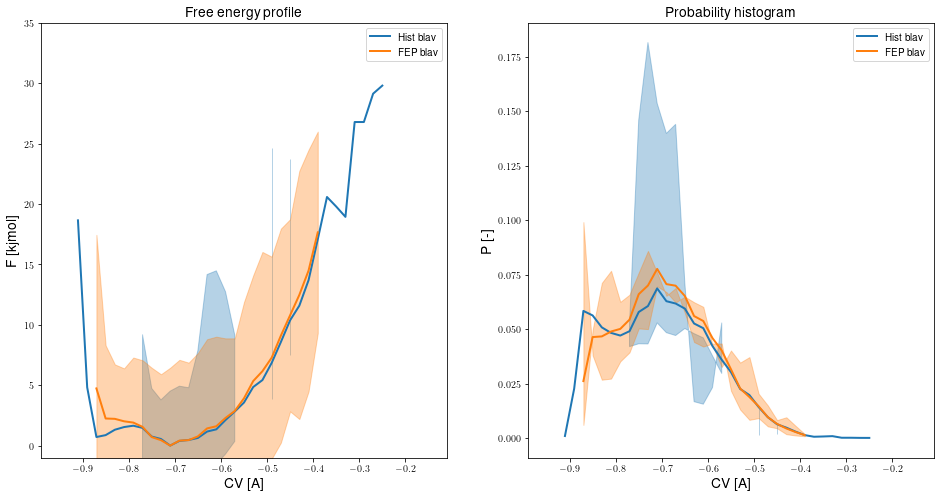

In [21]:
fep_blav_1 = BaseFreeEnergyProfile.from_histogram(hist_blav_1, temp=temp)
fep_blav_1.set_ref(ref='min')
fep_blav_2.set_ref(ref='min')
plot_feps('blav_compare.png', [fep_blav_1,fep_blav_2], labels=['Hist blav','FEP blav'], temp=temp, flim=35*kjmol)

## Construct histogram with error from bootstrapping

<Figure size 432x288 with 0 Axes>

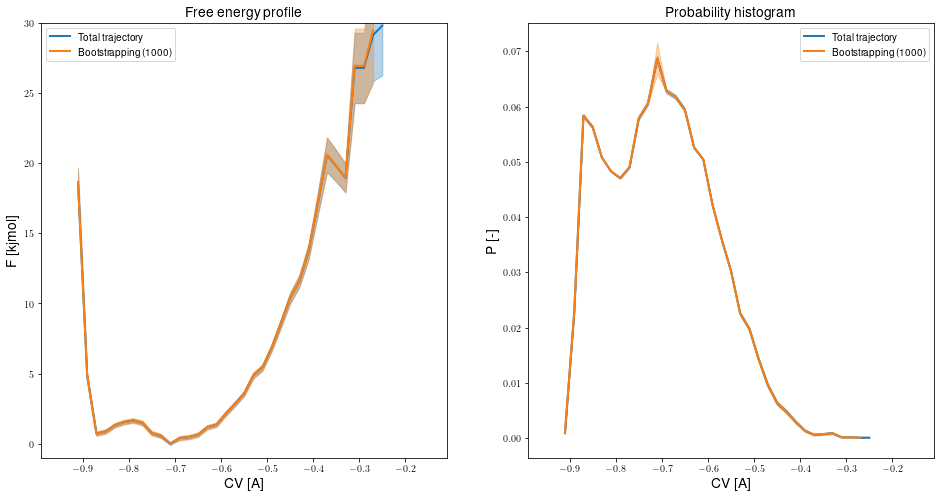

In [17]:
nboot = 1000
feps = []
for iboot in range(nboot):
    indices = np.random.randint(low=0, high=len(cv_data)-1, size=len(cv_data))
    hist = Histogram1D.from_single_trajectory(cv_data[indices], bins, error_estimate=None, cv_unit='A')
    fep = BaseFreeEnergyProfile.from_histogram(hist, temp)
    fep.set_ref('min')
    feps.append(fep)
fep_boot = BaseFreeEnergyProfile.from_average(feps, error_estimate='std', nsigma=2)
hist_total = Histogram1D.from_single_trajectory(cv_data, bins, error_estimate='mle_f', nsigma=2, cv_unit='A')
fep_total = BaseFreeEnergyProfile.from_histogram(hist_total, temp)
fep_total.set_ref('min')
plot_feps('fepboot.png', [fep_total, fep_boot], labels=['Total trajectory', 'Bootstrapping (%i)' %nboot], temp=temp, flim=30*kjmol)